import tensorflow as tf
import BHDVCS 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

func = BHDVCS.BHDVCS()

In [2]:

import tensorflow as tf
import BHDVCS 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

func = BHDVCS.BHDVCS()

In [3]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)

In [4]:
def chi_fit(g):
    data1 = pd.read_csv('data.csv')
    constants = np.array(data['dvcs'])[g:g+36]

    phi = np.array(data1['phi_x'])[g:g+36]
    F1 = np.array(data1['F1'])[g:g+36]
    F2 = np.array(data1['F2'])[g:g+36]

    q2 = np.array(data1['QQ'])[g:g+36]
    xb = np.array(data1['x_b'])[g:g+36]
    k = np.array(data1['k'])[g:g+36]
    t = np.array(data1['t'])[g:g+36]

    F = np.array(data1['F'])[g:g+36]
    errF = np.array(data1['errF'])[g:g+36]


    func = BHDVCS.BHDVCS()

    data1 = (phi, q2, xb, t, k, F1, F2, constants)

    params_fit, pcov = curve_fit(func.TotalUUXS_curve_fit, data1, F, sigma=errF)
    
    return params_fit

In [5]:
data = pd.read_csv('data.csv')

reh = np.array(data['ReH']).transpose()
ree = np.array(data['ReE']).transpose()
reht = np.array(data['ReHtilde']).transpose()

cff = np.concatenate((reh, ree, reht), axis=0)

g = 14
constants = np.array(data['dvcs'])[0:36*g+36]

phi = np.array(data['phi_x'])[0:36*g+36]
F1 = np.array(data['F1'])[0:36*g+36]
F2 = np.array(data['F2'])[0:36*g+36]

q2 = np.array(data['QQ'])[0:36*g+36]
xb = np.array(data['x_b'])[0:36*g+36]
k = np.array(data['k'])[0:36*g+36]
t = np.array(data['t'])[0:36*g+36]

tmean = np.mean(t)

print(tmean)

F = np.array(data['F'])[0:36*g+36]
errF = np.array(data['errF'])[0:36*g+36]

data = data.drop(columns=['#Set','index','F','errF','ReH','ReE','ReHtilde'])

cols = ['phi_x', 'QQ', 'x_b', 't', 'k', 'F1', 'F2', 'dvcs']

data = data.reindex(columns=cols)

-0.32391780000000003


In [49]:
def los(y_true, y_pred):
    try:
        a = np.where(reh == y_true[0].numpy())
        b = np.where(ree == y_true[1].numpy())
        c = np.where(reht == y_true[2].numpy())
        g = (a and b and c)[0][0]+1
    except:
        g = 0
    
    dat = data[g:g+1].to_numpy().transpose()    
    
    
    j = 0
    tot = 0
    for i in range(0,360,10):
        dat[0] = i
        tot += abs(func.TotalUUXS_curve_fit(dat, y_true[0], y_true[1], y_true[2])-func.TotalUUXS_curve_fit(dat, y_pred[0], y_pred[1], y_pred[2]))/errF[g]
        j+=1
    
    
    
    return (((pErr(y_pred[0], y_true[0]) + pErr(y_pred[1], y_true[1]) +pErr(y_pred[2], y_true[2]))/errF[g])**2)*((tot/errF[g])**2)

In [50]:
x_data = pd.read_csv('data.csv')
y_data = pd.read_csv('data.csv')
#,'dvcs'
#k,QQ,x_b,t,phi_x,F,errF,F1,F2,dvcs
x_data = x_data.drop(columns=['#Set','index','F','errF','ReH','ReE','ReHtilde','phi_x', 'F1', 'F2', 'dvcs'])
y_data = y_data.drop(columns=['#Set','index','k','QQ','x_b','phi_x','F','errF','F1','F2','dvcs'])


x_group_1 = x_data[x_data['t'] < tmean]
x_group_2 = x_data[x_data['t'] > tmean]


y_group_1 = y_data[y_data['t'] < tmean]
y_group_1 = y_group_1.drop(columns=['t'])

y_group_2 = y_data[y_data['t'] > tmean]
y_group_2 = y_group_2.drop(columns=['t'])



x1 = pd.DataFrame(x_group_1.loc[0:36*g+36:36]).to_numpy()
y1 = pd.DataFrame(y_group_1.loc[0:36*g+36:36]).to_numpy()
x2 = pd.DataFrame(x_group_2.loc[0:36*g+36:36]).to_numpy()
y2 = pd.DataFrame(y_group_2.loc[0:36*g+36:36]).to_numpy()



x = pd.DataFrame(x_data.loc[0:36*g+36:36]).to_numpy()
y = pd.DataFrame(y_data.loc[0:36*g+36:36]).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

iters = x_test.ndim

x_train, x_test, y_train,y_test = x_train / 255.0, x_test / 255.0,y_train / 255.0, y_test / 255.0

x = x/255.0
y = y/255.0

x1 = x1/255.0
y1 = y1/255.0
x2 = x2/255.0
y2 = y2/255.0

In [51]:
print(x1)
print(y1)

[[ 0.01470588  0.00682404  0.00170625 -0.0014936 ]
 [ 0.01470588  0.00798612  0.00162966 -0.00146469]
 [ 0.01862745  0.00798612  0.00162966 -0.00146469]
 [ 0.02254902  0.01032384  0.00135299 -0.00141642]
 [ 0.02254902  0.00798612  0.00162966 -0.00146469]
 [ 0.02647059  0.01032384  0.00135299 -0.00141642]
 [ 0.03039216  0.01032384  0.00135299 -0.00141642]]
[[ 0.05119765 -0.20806039  0.02844322]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.04604353 -0.20290627  0.02557973]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.04604353 -0.20290627  0.02557973]
 [ 0.04604353 -0.20290627  0.02557973]]


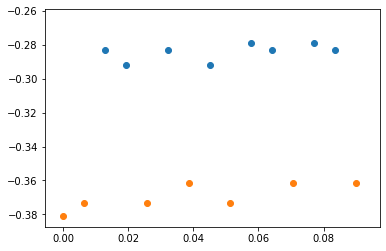

In [19]:
X = np.array((np.linspace(0,.09,15).transpose(),t[0: 36*g+36: 36].transpose())).T

# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [20]:
def pErr(a, b):
    return abs((a - b)/ (b))

In [21]:
def mlfit(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    
    
    for i in range(1000):
        
        model = tf.keras.models.Sequential()
        model.add(tf.keras.Input(shape=(4,)))

        model.add(tf.keras.layers.Dense(128, activation='tanh'))
        model.add(tf.keras.layers.Dense(32, activation='tanh'))
        model.add(tf.keras.layers.Dense(100, activation='relu'))
        model.add(tf.keras.layers.Dense(500, activation='relu'))


        model.add(tf.keras.layers.Dense(128, activation='tanh'))
        model.add(tf.keras.layers.Dense(32, activation='tanh'))
        model.add(tf.keras.layers.Dense(100, activation='relu'))
        model.add(tf.keras.layers.Dense(500, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='tanh'))
        model.add(tf.keras.layers.Dense(32, activation='tanh'))
        model.add(tf.keras.layers.Dense(100, activation='relu'))
        model.add(tf.keras.layers.Dense(500, activation='relu'))



        model.add(tf.keras.layers.Dense(3))


    model.compile(optimizer='adam', loss=los)
    model.fit(x_train, y_train, epochs=1000)

    return model.predict(x_test)*255.0

In [22]:
def graph_fit(reh, ree, reht, g):
    curve_fit_points = []
    data2 = pd.read_csv('data.csv')
    dvcs = np.array(data['dvcs'])[g:g+36]

    phi = np.array(data2['phi_x'])[g:g+36]
    F1 = np.array(data2['F1'])[g:g+36]
    F2 = np.array(data2['F2'])[g:g+36]

    q2 = np.array(data2['QQ'])[g:g+36]
    xb = np.array(data2['x_b'])[g:g+36]
    k = np.array(data2['k'])[g:g+36]
    t = np.array(data2['t'])[g:g+36]

    F = np.array(data2['F'])[g:g+36]
    errF = np.array(data2['errF'])[g:g+36]

    for p in range(0, 36):
                  
        pars = [q2[p], xb[p], t[p], k[p], reh, ree, reh, ree, reht, dvcs[p]]
        angle = [phi[p]]
        curve_fit_points.append(func.TotalUUXS(angle, pars)) 
      
    plt.plot(phi, curve_fit_points, 'r--', alpha=0.5, label='Curve Fit') # plot the raw data
    plt.errorbar(phi, F, errF,  None, 'bo', label='t={0} x_b={1} Q={2}'.format(t[0],xb[0], q2[0]), alpha=0.8) # plot the raw data
    plt.xlabel('X value')
    plt.ylabel('Observables')
    plt.legend()
    plt.show()

In [23]:



arr1 = mlfit(x1, y1)
arr2 = mlfit(x2, y2)

Epoch 1/1000
Tensor("los/add_5:0", shape=(3,), dtype=float32)
Tensor("los/add_5:0", shape=(3,), dtype=float32)
1/1 [==============================] - 0s 1ms/step - loss: 74276082286592.0000
Epoch 2/1000
1/1 [==============================] - 0s 998us/step - loss: 53038328840192.0000
Epoch 3/1000
1/1 [==============================] - 0s 999us/step - loss: 23035989983232.0000
Epoch 4/1000
1/1 [==============================] - 0s 999us/step - loss: 3480519442432.0000
Epoch 5/1000
1/1 [==============================] - 0s 999us/step - loss: 238904672256.0000
Epoch 6/1000
1/1 [==============================] - 0s 997us/step - loss: 8455985823744.0000
Epoch 7/1000
1/1 [==============================] - 0s 996us/step - loss: 1802836639744.0000
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 310955180032.0000
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 276720091136.0000
Epoch 10/1000
1/1 [==============================] - 0s 998us/step - lo

1/1 [==============================] - 0s 3ms/step - loss: 20796078.0000
Epoch 185/1000
1/1 [==============================] - 0s 3ms/step - loss: 23916370.0000
Epoch 186/1000
1/1 [==============================] - 0s 3ms/step - loss: 22795926.0000
Epoch 187/1000
1/1 [==============================] - 0s 994us/step - loss: 1939331.6250
Epoch 188/1000
1/1 [==============================] - 0s 3ms/step - loss: 24231418.0000
Epoch 189/1000
1/1 [==============================] - 0s 2ms/step - loss: 19996084.0000
Epoch 190/1000
1/1 [==============================] - 0s 2ms/step - loss: 19172898.0000
Epoch 191/1000
1/1 [==============================] - 0s 2ms/step - loss: 26749896.0000
Epoch 192/1000
1/1 [==============================] - 0s 2ms/step - loss: 9303023.0000
Epoch 193/1000
1/1 [==============================] - 0s 1ms/step - loss: 4051455.7500
Epoch 194/1000
1/1 [==============================] - 0s 3ms/step - loss: 33826156.0000
Epoch 195/1000
1/1 [============================

1/1 [==============================] - 0s 2ms/step - loss: 3380535.2500
Epoch 371/1000
1/1 [==============================] - 0s 2ms/step - loss: 7050629.5000
Epoch 372/1000
1/1 [==============================] - 0s 2ms/step - loss: 27332374.0000
Epoch 373/1000
1/1 [==============================] - 0s 998us/step - loss: 40027984.0000
Epoch 374/1000
1/1 [==============================] - 0s 2ms/step - loss: 9795389.0000
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 10624744.0000
Epoch 376/1000
1/1 [==============================] - 0s 998us/step - loss: 29327626.0000
Epoch 377/1000
1/1 [==============================] - 0s 2ms/step - loss: 9242459.0000
Epoch 378/1000
1/1 [==============================] - 0s 4ms/step - loss: 9680991.0000
Epoch 379/1000
1/1 [==============================] - 0s 4ms/step - loss: 6514346.0000
Epoch 380/1000
1/1 [==============================] - 0s 997us/step - loss: 28039810.0000
Epoch 381/1000
1/1 [===========================

1/1 [==============================] - 0s 2ms/step - loss: 47866000.0000
Epoch 557/1000
1/1 [==============================] - 0s 2ms/step - loss: 33812412.0000
Epoch 558/1000
1/1 [==============================] - 0s 3ms/step - loss: 1999750.0000
Epoch 559/1000
1/1 [==============================] - 0s 983us/step - loss: 33356742.0000
Epoch 560/1000
1/1 [==============================] - 0s 2ms/step - loss: 15021660.0000
Epoch 561/1000
1/1 [==============================] - 0s 2ms/step - loss: 13785267.0000
Epoch 562/1000
1/1 [==============================] - 0s 3ms/step - loss: 14273407.0000
Epoch 563/1000
1/1 [==============================] - 0s 3ms/step - loss: 7565690.0000
Epoch 564/1000
1/1 [==============================] - 0s 2ms/step - loss: 3224383.2500
Epoch 565/1000
1/1 [==============================] - 0s 2ms/step - loss: 3674631.2500
Epoch 566/1000
1/1 [==============================] - 0s 2ms/step - loss: 26266992.0000
Epoch 567/1000
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 4203093.5000
Epoch 743/1000
1/1 [==============================] - 0s 998us/step - loss: 33039234.0000
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - loss: 30926582.0000
Epoch 745/1000
1/1 [==============================] - 0s 999us/step - loss: 5590338.0000
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 6869886.5000
Epoch 747/1000
1/1 [==============================] - 0s 997us/step - loss: 23657938.0000
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 22318250.0000
Epoch 749/1000
1/1 [==============================] - 0s 2ms/step - loss: 21127740.0000
Epoch 750/1000
1/1 [==============================] - 0s 2ms/step - loss: 18132358.0000
Epoch 751/1000
1/1 [==============================] - 0s 997us/step - loss: 13487632.0000
Epoch 752/1000
1/1 [==============================] - 0s 996us/step - loss: 37227220.0000
Epoch 753/1000
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 38153.6406
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 9914325.0000
Epoch 930/1000
1/1 [==============================] - 0s 2ms/step - loss: 184818.7344
Epoch 931/1000
1/1 [==============================] - 0s 2ms/step - loss: 9976579.0000
Epoch 932/1000
1/1 [==============================] - 0s 993us/step - loss: 3134907.2500
Epoch 933/1000
1/1 [==============================] - 0s 998us/step - loss: 7106430.0000
Epoch 934/1000
1/1 [==============================] - 0s 3ms/step - loss: 15261685.0000
Epoch 935/1000
1/1 [==============================] - 0s 995us/step - loss: 46827.5625
Epoch 936/1000
1/1 [==============================] - 0s 3ms/step - loss: 128386.1797
Epoch 937/1000
1/1 [==============================] - 0s 2ms/step - loss: 160152.1094
Epoch 938/1000
1/1 [==============================] - 0s 1ms/step - loss: 49853.3789
Epoch 939/1000
1/1 [==============================] - 0s 995

1/1 [==============================] - 0s 998us/step - loss: 6092767232.0000
Epoch 21/1000
1/1 [==============================] - 0s 996us/step - loss: 3972524544.0000
Epoch 22/1000
1/1 [==============================] - 0s 1ms/step - loss: 3076370432.0000
Epoch 23/1000
1/1 [==============================] - 0s 1ms/step - loss: 1596920704.0000
Epoch 24/1000
1/1 [==============================] - 0s 998us/step - loss: 2431220480.0000
Epoch 25/1000
1/1 [==============================] - 0s 1ms/step - loss: 3282844416.0000
Epoch 26/1000
1/1 [==============================] - 0s 1000us/step - loss: 5698405888.0000
Epoch 27/1000
1/1 [==============================] - 0s 998us/step - loss: 3677646848.0000
Epoch 28/1000
1/1 [==============================] - 0s 999us/step - loss: 1218688640.0000
Epoch 29/1000
1/1 [==============================] - 0s 1ms/step - loss: 1222215296.0000
Epoch 30/1000
1/1 [==============================] - 0s 1ms/step - loss: 923963072.0000
Epoch 31/1000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 2998949.7500
Epoch 208/1000
1/1 [==============================] - 0s 0s/step - loss: 1375447.5000
Epoch 209/1000
1/1 [==============================] - 0s 998us/step - loss: 576402.5625
Epoch 210/1000
1/1 [==============================] - 0s 1000us/step - loss: 9383182.0000
Epoch 211/1000
1/1 [==============================] - 0s 1ms/step - loss: 3191415.7500
Epoch 212/1000
1/1 [==============================] - 0s 1ms/step - loss: 2858043.2500
Epoch 213/1000
1/1 [==============================] - 0s 1ms/step - loss: 140740.7031
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 7980040.0000
Epoch 215/1000
1/1 [==============================] - 0s 1ms/step - loss: 2873425.2500
Epoch 216/1000
1/1 [==============================] - 0s 0s/step - loss: 1916992.7500
Epoch 217/1000
1/1 [==============================] - 0s 1ms/step - loss: 3306060.0000
Epoch 218/1000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 2ms/step - loss: 1116760.2500
Epoch 302/1000
1/1 [==============================] - 0s 2ms/step - loss: 2747259.2500
Epoch 303/1000
1/1 [==============================] - 0s 998us/step - loss: 3628998.0000
Epoch 304/1000
1/1 [==============================] - 0s 1ms/step - loss: 2613217.7500
Epoch 305/1000
1/1 [==============================] - 0s 1000us/step - loss: 38663.0508
Epoch 306/1000
1/1 [==============================] - 0s 998us/step - loss: 3571228.0000
Epoch 307/1000
1/1 [==============================] - 0s 2ms/step - loss: 2121166.2500
Epoch 308/1000
1/1 [==============================] - 0s 1ms/step - loss: 34335.2500
Epoch 309/1000
1/1 [==============================] - 0s 998us/step - loss: 4561720.5000
Epoch 310/1000
1/1 [==============================] - 0s 1ms/step - loss: 21330.8887
Epoch 311/1000
1/1 [==============================] - 0s 998us/step - loss: 1502258.6250
Epoch 312/1000
1/1 [==============================] -

1/1 [==============================] - 0s 1ms/step - loss: 1364420.0000
Epoch 489/1000
1/1 [==============================] - 0s 0s/step - loss: 3554544.7500
Epoch 490/1000
1/1 [==============================] - 0s 0s/step - loss: 1943940.7500
Epoch 491/1000
1/1 [==============================] - 0s 1ms/step - loss: 153986.8594
Epoch 492/1000
1/1 [==============================] - ETA: 0s - loss: 5312371.500 - 0s 1000us/step - loss: 5312371.5000
Epoch 493/1000
1/1 [==============================] - 0s 0s/step - loss: 2541743.0000
Epoch 494/1000
1/1 [==============================] - 0s 998us/step - loss: 5383014.5000
Epoch 495/1000
1/1 [==============================] - 0s 1ms/step - loss: 4955579.5000
Epoch 496/1000
1/1 [==============================] - 0s 1000us/step - loss: 3800182.5000
Epoch 497/1000
1/1 [==============================] - 0s 996us/step - loss: 164021.1406
Epoch 498/1000
1/1 [==============================] - 0s 997us/step - loss: 498039.5938
Epoch 499/1000
1/1 [==

1/1 [==============================] - 0s 1ms/step - loss: 1994170.0000
Epoch 676/1000
1/1 [==============================] - 0s 0s/step - loss: 892863.3750
Epoch 677/1000
1/1 [==============================] - 0s 968us/step - loss: 1361840.1250
Epoch 678/1000
1/1 [==============================] - 0s 999us/step - loss: 393178.5938
Epoch 679/1000
1/1 [==============================] - 0s 1000us/step - loss: 392336.2188
Epoch 680/1000
1/1 [==============================] - 0s 998us/step - loss: 877331.8125
Epoch 681/1000
1/1 [==============================] - 0s 996us/step - loss: 1006972.8125
Epoch 682/1000
1/1 [==============================] - 0s 997us/step - loss: 2009153.6250
Epoch 683/1000
1/1 [==============================] - 0s 996us/step - loss: 320633.7188
Epoch 684/1000
1/1 [==============================] - 0s 951us/step - loss: 3568609.5000
Epoch 685/1000
1/1 [==============================] - 0s 0s/step - loss: 1980334.7500
Epoch 686/1000
1/1 [============================

Epoch 863/1000
1/1 [==============================] - 0s 997us/step - loss: 3418899.5000
Epoch 864/1000
1/1 [==============================] - 0s 1ms/step - loss: 5019236.5000
Epoch 865/1000
1/1 [==============================] - 0s 0s/step - loss: 3131126.2500
Epoch 866/1000
1/1 [==============================] - 0s 0s/step - loss: 14456142.0000
Epoch 867/1000
1/1 [==============================] - 0s 998us/step - loss: 820630.1875
Epoch 868/1000
1/1 [==============================] - 0s 0s/step - loss: 5458554.0000
Epoch 869/1000
1/1 [==============================] - 0s 1ms/step - loss: 799425.0625
Epoch 870/1000
1/1 [==============================] - 0s 1000us/step - loss: 4217628.5000
Epoch 871/1000
1/1 [==============================] - 0s 1ms/step - loss: 2779426.0000
Epoch 872/1000
1/1 [==============================] - 0s 0s/step - loss: 760060.0625
Epoch 873/1000
1/1 [==============================] - 0s 1ms/step - loss: 4406604.5000
Epoch 874/1000
1/1 [======================

Epoch 957/1000
1/1 [==============================] - 0s 1ms/step - loss: 2842919.0000
Epoch 958/1000
1/1 [==============================] - 0s 998us/step - loss: 2409589.7500
Epoch 959/1000
1/1 [==============================] - 0s 1ms/step - loss: 2201552.7500
Epoch 960/1000
1/1 [==============================] - 0s 995us/step - loss: 4310349.5000
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 776676.2500
Epoch 962/1000
1/1 [==============================] - 0s 0s/step - loss: 1319436.3750
Epoch 963/1000
1/1 [==============================] - 0s 997us/step - loss: 1323826.3750
Epoch 964/1000
1/1 [==============================] - 0s 1ms/step - loss: 1820873.7500
Epoch 965/1000
1/1 [==============================] - 0s 1ms/step - loss: 5594918.0000
Epoch 966/1000
1/1 [==============================] - 0s 1ms/step - loss: 1879542.6250
Epoch 967/1000
1/1 [==============================] - 0s 1ms/step - loss: 47410.9180
Epoch 968/1000
1/1 [=====================

[[  7.109659  -47.148106    3.9468   ]
 [  7.107616  -47.136173    3.9452045]
 [  7.100719  -47.10638     3.9428618]]
Errors Set  0 :
Set 1
Real  ReH 13.0554 ReE -53.0554 ReHT 7.253019999999999
Predicted ReH 11.932889 ReE -51.764946 ReHT 6.629569
 
Chi  ReH 0.06306624460049916 ReE 0.08157402621155244 ReHT 0.062496882532626315
ML  ReH 0.085980591580482 ReE 0.02432276481024137 ReHT 0.08595742826437774
 
ERROR Greater than 5%


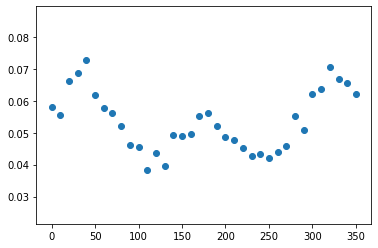

Errors Set  1 :
Set 1
Real  ReH 12.5549 ReE -52.5549 ReHT 6.974939999999999
Predicted ReH 12.292973 ReE -52.359802 ReHT 6.823347
 
Chi  ReH 0.06651456236466628 ReE 0.09149851077187778 ReHT 0.07356328618281023
ML  ReH 0.020862566432447438 ReE 0.0037122657241523338 ReHT 0.02173393725611899
 


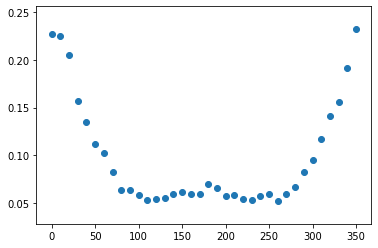

Errors Set  2 :
Set 1
Real  ReH 12.5549 ReE -52.5549 ReHT 6.974939999999999
Predicted ReH 11.721196 ReE -51.41836 ReHT 6.5127983
 
Chi  ReH 0.06651456236466628 ReE 0.09149851077187778 ReHT 0.07356328618281023
ML  ReH 0.06640465677770575 ReE 0.02162573492065714 ReHT 0.06625744317138606
 
ERROR Greater than 5%


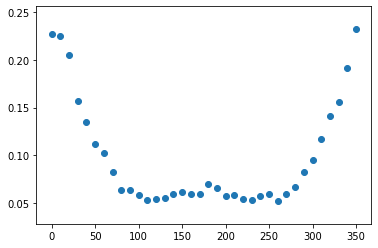

Errors Set  3 :
Set 2
Real  ReH 7.224239999999999 ReE -47.2242 ReHT 4.01347
Predicted ReH 7.109659 ReE -47.148106 ReHT 3.9468
 
Chi  ReH 0.09459516432642315 ReE 0.08530219227052974 ReHT 0.11741215571979306
ML  ReH 0.015860603337335147 ReE 0.001611342884836856 ReHT 0.016611562185586345
 


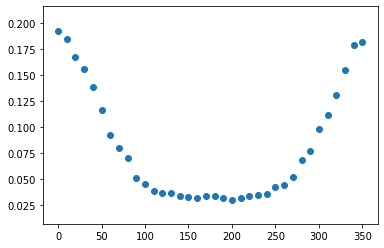

Errors Set  4 :
Set 2
Real  ReH 7.6527199999999995 ReE -47.6527 ReHT 4.25151
Predicted ReH 7.107616 ReE -47.136173 ReHT 3.9452045
 
Chi  ReH 0.17371803363555113 ReE 0.14339344015608185 ReHT 0.06222013051317005
ML  ReH 0.07123010541044372 ReE 0.010839401580791587 ReHT 0.07204628558237725
 
ERROR Greater than 5%


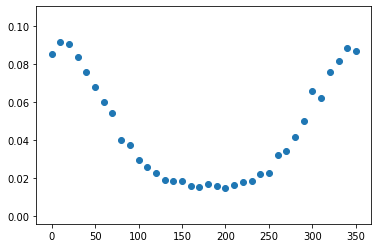

In [31]:


p, d = 0, 0
errReh = np.zeros(9)
errRee = np.zeros(9)
errReht = np.zeros(9)

for i in range(0, 5):#9):#iters):
    
    print("Errors Set ", i,":" )
    try:
        a = np.where(reh == y1[p][0]*255)
        b = np.where(ree == y1[p][1]*255)
        c = np.where(reht == y1[p][2]*255)
        g = (a and b and c)[0][0]
        
        params_fit = chi_fit(g)
        
        reh_chi = pErr(params_fit[0], y1[p][0]*255)
        ree_chi = pErr(params_fit[1], y1[p][1]*255)
        reht_chi = pErr(params_fit[2], y1[p][2]*255)
        
        reh_ml = pErr(arr1[p][0], y1[p][0]*255)
        ree_ml = pErr(arr1[p][1], y1[p][1]*255)
        reht_ml = pErr(arr1[p][2], y1[p][2]*255)
        print("Set 1")
        print("Real  ReH", (y1[p][0]*255), "ReE", (y1[p][1]*255), "ReHT", (y1[p][2]*255))
        print("Predicted ReH", arr1[p][0], "ReE", arr1[p][1], "ReHT", arr1[p][2] )
        
        p = p+1
    except:
        a = np.where(reh == y2[d][0]*255)
        b = np.where(ree == y2[d][1]*255)
        c = np.where(reht == y2[d][2]*255)
        g = (a and b and c)[0][0]
        
        params_fit = chi_fit(g)
        
        reh_chi = pErr(params_fit[0] , y2[d][0]*255)
        ree_chi = pErr(params_fit[1] , y2[d][1]*255)
        reht_chi = pErr(params_fit[2] , y2[d][2]*255)
        
        reh_ml = pErr(arr2[d][0], y2[d][0]*255)
        ree_ml = pErr(arr2[d][1], y2[d][1]*255)
        reht_ml = pErr(arr2[d][2], y2[d][2]*255)
        
        print("Set 2")
        print("Real  ReH", (y2[d][0]*255), "ReE", (y2[d][1]*255), "ReHT", (y2[d][2]*255))
        print("Predicted ReH", arr2[d][0], "ReE", arr2[d][1], "ReHT", arr2[d][2] )
        
        d=d+1

    print(" ")
    print("Chi  ReH", abs(reh_chi), "ReE", abs(ree_chi), "ReHT", abs(reht_chi))
    print("ML  ReH", abs(reh_ml), "ReE", abs(ree_ml), "ReHT", abs(reht_ml))
    print(" ")
    
    errReh[i] = reh_ml
    errRee[i] = ree_ml
    errReht[i] = reht_ml
    
    if abs((reh_ml) > 0.05) or (abs(ree_ml) > 0.05) or (abs(reht_ml) > 0.05):
        print("ERROR Greater than 5%")
    
    data1 = pd.read_csv('data.csv')
    phi = np.array(data1['phi_x'])[g:g+36]
    F = np.array(data1['F'])[g:g+36]
    errF = np.array(data1['errF'])[g:g+36]
    
    plt.scatter(phi, F)#, errF)
    plt.show()

In [12]:
print("Varience in ReH error",np.var(errReh))
print("Varience in ReE error",np.var(errRee))
print("Varience in ReHT error",np.var(errReht))

Varience in ReH error 0.0007500384980792575
Varience in ReE error 5.807901489218905e-05
Varience in ReHT error 0.0007365273089628503


In [34]:
setCounter = 0
set_data = np.zeros(36)

def setData(dat):
    global set_data
    set_data = dat


def los2(y_true, y_pred):
    
    
    
    real_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    
    dat = data[0:1].to_numpy().transpose()    
    
    
    j = 0
    tot = 0
    for i in range(0,360,10):
        dat[0] = i
        tot += abs(set_data-func.TotalUUXS_curve_fit(dat, y_pred[0], y_pred[1], y_pred[2]))/errF[g]
        
        
        
        
        
        
        j+=1
    
    
    
    return (((pErr(y_pred[0], y_true[0]) + pErr(y_pred[1], y_true[1]) +pErr(y_pred[2], y_true[2]))/errF[g])**2)*((tot/errF[g])**2)

In [25]:
def mlfit2(x, y):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(4,)))

    model.add(tf.keras.layers.Dense(128, activation='tanh'))
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(500, activation='relu'))


    model.add(tf.keras.layers.Dense(128, activation='tanh'))
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='tanh'))
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(500, activation='relu'))



    model.add(tf.keras.layers.Dense(3))
    
    data = pd.read_csv('data.csv')
    for i in range(14):
        for j in range(1000):
            
            data = DvcsData(data)
            set0 = data.getSet(i)
        
            setData(np.asarray(set0.XnoCFF).T)
        
        
            X_train = np.asarray(set0.Kinematics).T # have to take transpose to get everything to work
            y_sample = np.asarray(set0.sampleY())
            
            y_data = data.loc[:, ['ReH', 'ReE', 'ReHtilde']].to_numpy()[36*i:36*i+36]
            
            
            model.compile(optimizer='adam', loss=los)
            model.fit(x_train, y_data, epochs=10)
        
        
    return model.predict(x_test)*255.0

In [26]:
data = pd.read_csv('data.csv')
data = DvcsData(data)
set0 = data.getSet(0)
X_train = np.asarray(set0.Kinematics).T # have to take transpose to get everything to work
y_sample = np.asarray(set0.sampleY())

In [38]:
data = np.asarray(set0.XnoCFF)
print(np.asarray(set0.XnoCFF))

'''
'phi_x', 'QQ', 'x_b', 't', 'k', 'F1', 'F2', 'dvcs'
'phi_x' 0  ,'QQ'1.74013 'x_b' 0.435095 't' -0.380868  'k'3.75 'F1' 0.498060  'F2'0.68579  'dvcs'0.012288 
10  1.74013  0.435095 -0.380868  3.75  0.498060  0.68579  0.012288
'''

dataset = pd.DataFrame({'phi_x': data[:, 0], 'QQ': data[:, 2], 'x_b': data[:, 3], 't':data[:, 4], 'k': data[:, 1], 'F1': data[:, 5], 'F2': data[:, 6], 'dvcs': data[:, 7]})
print(dataset)

[[ 0.00000e+00  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 1.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 2.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 3.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 4.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 5.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 6.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 7.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 8.00000e+01  3.75000e+00  1.74013e+00  4.35095e-01 -3.80868e-01
   4.98060e-01  6.85790e-01  1.22881e-02]
 [ 9.00000e+01  3.7

In [28]:
print(y_sample)

[0.05951674 0.05854742 0.06238542 0.07663388 0.07601199 0.06085709
 0.05632881 0.05625143 0.05286365 0.04890234 0.04616052 0.0405963
 0.04326621 0.0386298  0.04625594 0.04713063 0.0496678  0.05704861
 0.05854732 0.05657304 0.0492988  0.04853606 0.04172323 0.04408311
 0.04592173 0.04094018 0.04559656 0.04437071 0.05204375 0.05030169
 0.06159452 0.0624491  0.06632851 0.06898931 0.0600408  0.06542731]


In [35]:
for i in range (20):
    data = pd.read_csv('data.csv')
    data = DvcsData(data)
    set0 = data.getSet(0)
    setData(np.asarray(set0.XnoCFF).T)
    X_train = np.asarray(set0.Kinematics).T # have to take transpose to get everything to work
    y_sample = np.asarray(set0.sampleY())
    
    setData(y_sample)
    
    arr1 = mlfit2(X_train, y1)
    

Epoch 1/1000


TypeError: in user code:

    C:\Users\bijan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-17-abf1eeaf08c4>:10 los  *
        dat = data[g:g+1].to_numpy().transpose()

    TypeError: 'DvcsData' object is not subscriptable


In [42]:
data = pd.read_csv('data.csv')
print(data.loc[:, ['ReH', 'ReE', 'ReHtilde']].to_numpy())

[[ 13.0554  -53.0554    7.25302]
 [ 13.0554  -53.0554    7.25302]
 [ 13.0554  -53.0554    7.25302]
 ...
 [ 11.7411  -51.7411    6.52283]
 [ 11.7411  -51.7411    6.52283]
 [ 11.7411  -51.7411    6.52283]]


[[ 0.01470588  0.00682404  0.00170625 -0.0014936 ]
 [ 0.01470588  0.00798612  0.00162966 -0.00146469]
 [ 0.01862745  0.00798612  0.00162966 -0.00146469]
 [ 0.02254902  0.01032384  0.00135299 -0.00141642]
 [ 0.02254902  0.00798612  0.00162966 -0.00146469]
 [ 0.02647059  0.01032384  0.00135299 -0.00141642]
 [ 0.03039216  0.01032384  0.00135299 -0.00141642]]
[[ 0.05119765 -0.20806039  0.02844322]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.04604353 -0.20290627  0.02557973]
 [ 0.0492349  -0.20609765  0.02735271]
 [ 0.04604353 -0.20290627  0.02557973]
 [ 0.04604353 -0.20290627  0.02557973]]
